# Building the Baseline Model using K-Means

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
# Grab dataframe containing police reports
# Create df on Macbook
# df = pd.read_csv("/Users/garrettyamane/Desktop/Springboard/capstone_project_1_data/merged.csv")

# Create df on PC
df = pd.read_csv("/Users/Garrett/Desktop/Springboard/capstone_project_1_data/merged.csv")
df = df.drop(columns='Unnamed: 0')

In [3]:
def label_hour(row):
    """Return either monring, afternoon, evening, or night depending on the hour of the day"""
    hour = int(row["Incident Hour"])
    if hour >= 5 and hour < 12: #5:00am to 11:59am
        return 'morning'
    elif hour >= 12 and hour < 17: #12:00pm to 4:59pm
        return 'afternoon'
    elif hour >= 17 and hour < 21: # 5:00pm to 8:59pm
        return 'evening'
    return 'night' # 9:00pm to 4:49am


def label_season(row):
    """Return either spring, summer, fall, or winter depending on the month of the year"""
    month = row["Incident Month"]
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    fall = [9, 10, 11]
    winter = [12, 1, 2]
    
    if month in spring:
        return 'spring'
    elif month in summer:
        return 'summer'
    elif month in fall:
        return 'fall'
    return 'winter'

# Add "Hour" and "Month" columns
df["Incident Month"] = pd.to_datetime(df["Incident Date"]).dt.month
df["Incident Hour"] = df["Incident Time"].str.split(':').str[0]

# Add "season" and "time categories" columns
df['Time Category'] = df.apply(lambda row: label_hour(row), axis=1)
df['Season'] = df.apply(lambda row: label_season(row), axis=1)

# Generating dummy variables for categorical features
I am deciding to focus on a smaller dataset of 5000 crime reports to generate my initial baseline model for k-means. I sampled 5000 reports from the Crime Data Warehouse data (reports from 2018 onward in my original data frame).

In [4]:
# Crime Data Warehouse Data Frame
cdw_df = df[df["Incident Year"] > 2017]

In [78]:
# Create dummy variables for categorical crime features to be used for k-means model
dummies_df = pd.get_dummies(data=cdw_df, columns=["Incident Category", "Incident Day of Week", "Police District", "Time Category", "Season"])
dummy_cols = dummies_df.iloc[:, 14:]

In [79]:
dummy_cols.head()

,Incident Category_Arson,Incident Category_Assault,Incident Category_Burglary,Incident Category_Case Closure,Incident Category_Civil Sidewalks,Incident Category_Courtesy Report,Incident Category_Disorderly Conduct,Incident Category_Drug Offense,Incident Category_Drug Violation,Incident Category_Embezzlement,...,Police District_Taraval,Police District_Tenderloin,Time Category_afternoon,Time Category_evening,Time Category_morning,Time Category_night,Season_fall,Season_spring,Season_summer,Season_winter
2168356,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2168357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2168358,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2168359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2168360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


# Choosing the appropriate *K* value: The Elbow Sum-of-Squares Method
The first method I am using to choose my k value is using the sum-of-squares error for each cluster, and plotting each error against k to choose the "elbow" of the resulting plot.

In [80]:
# Convert dummy data frame to numpy array
dummy_np_arr = dummy_cols.to_numpy()

In [82]:
def get_SS_vals(data, k_min, k_max):
    """Gets Sum-of-Squares for each k value for each value in range(k_min, k_max + 1)"""
    kmeans_model = KMeans()
    kmeans_model.fit(dummy_np_arr)

    ss_vals = []
    
    for k in range(k_min, k_max+1):
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit(dummy_np_arr)
        ss_vals.append(kmeans_model.inertia_)
    
    return ss_vals

In [83]:
# Get sum-of-squares errors for k values 2 <= k <= 10
ss_vals = get_SS_vals(dummy_np_arr, 2, 10)

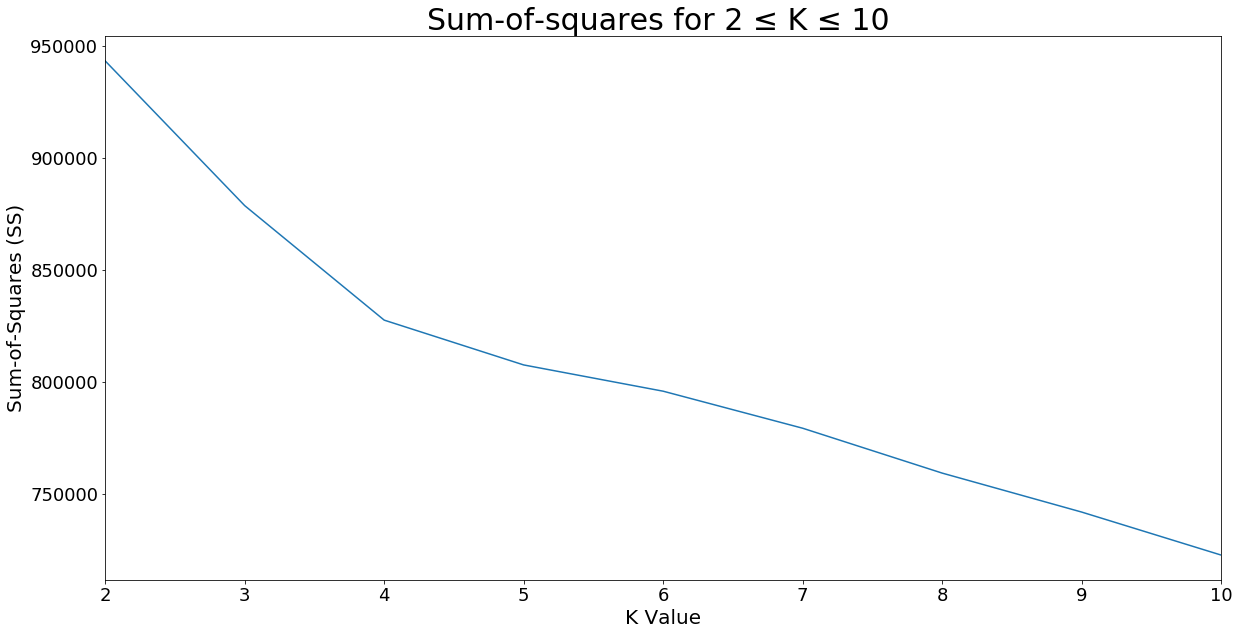

In [89]:
# Plot sum-of-squares against each k value
plt.figure(figsize=(20,10))
    
plt.plot(range(2, 11), ss_vals)
plt.xlim([2,10])
plt.xlabel('K Value', fontsize=20)
plt.ylabel('Sum-of-Squares (SS)', fontsize=20)
plt.xticks(range(2,11), size = 18)
plt.yticks(size = 18)
plt.title('Sum-of-squares for 2 ≤ K ≤ 10 ', size=30)
plt.show()

#### Response:
From the graph, it appears that the 'elbow point' where the graph descends slower is at k=4. To test this against another method of choosing the best k-value, I will also use the silhouette method and compare the results.

# Choosing the appropriate *K* value: The Silhouette Method
I initially ran the Silhouette Method on the full Crime Data Warehouse dataset, and the runtime took multiple hours for larger k values. For testing purposes, I am deciding to focus on a smaller dataset of 5000 randomly sampled crime reports to run the Silhouette method on.

In [14]:
# Generate a smaller sample of the Crime Data Warehouse Data Frame for Silouette Method 
random.seed(41)
sample = cdw_df.sample(5000)

# Create dummy variables for categorical crime features to be used for k-means model
dummy_sample_df = pd.get_dummies(data=sample, columns=["Incident Category", "Incident Day of Week", "Police District", "Time Category", "Season"])
dummy_sample_cols = dummy_sample_df.iloc[:, 14:]
dummy_sample_np_arr = dummy_sample_cols.to_numpy()

For k = 2 The average silhouette_score is : 0.06945017635536661
For k = 3 The average silhouette_score is : 0.10029363429364077
For k = 4 The average silhouette_score is : 0.12199008832235281
For k = 5 The average silhouette_score is : 0.0919495506371363
For k = 6 The average silhouette_score is : 0.08591651498779876
For k = 7 The average silhouette_score is : 0.08390133401181893
For k = 8 The average silhouette_score is : 0.0917952894370174
For k = 9 The average silhouette_score is : 0.0953053495570164
For k = 10 The average silhouette_score is : 0.10073114551971722


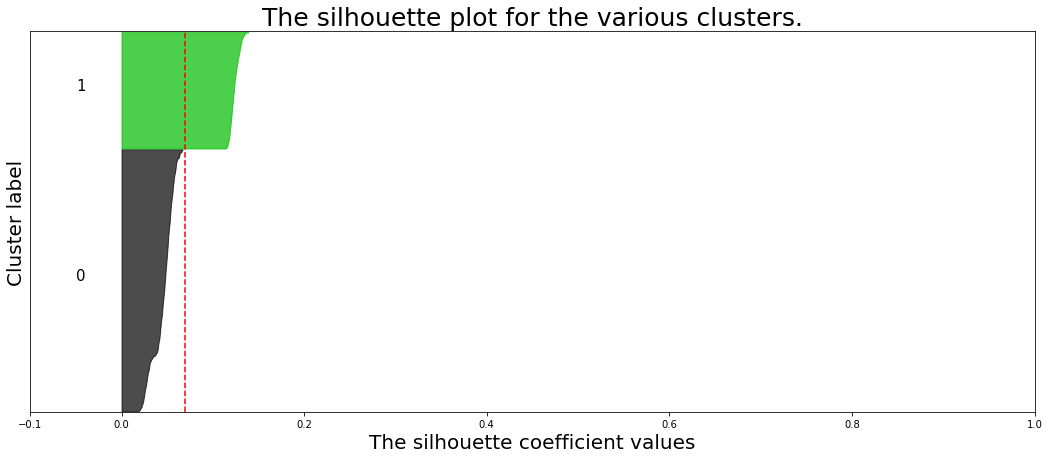

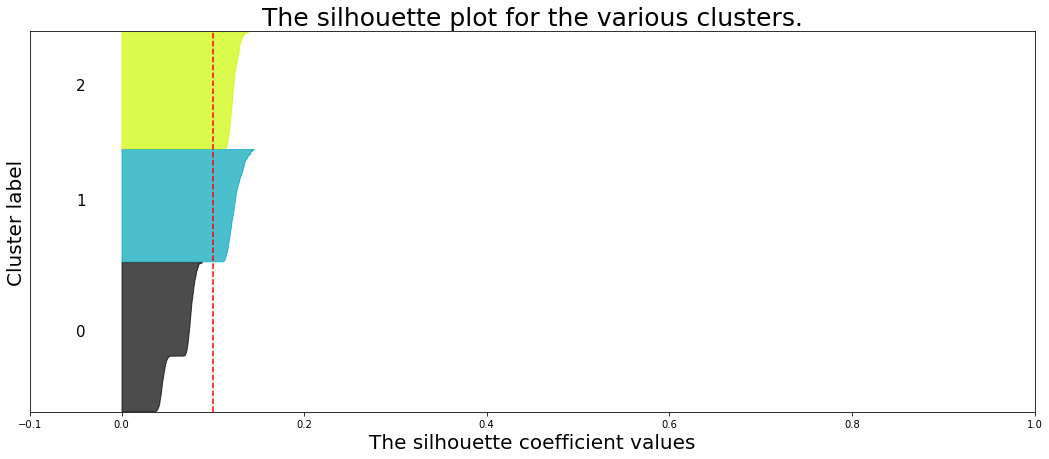

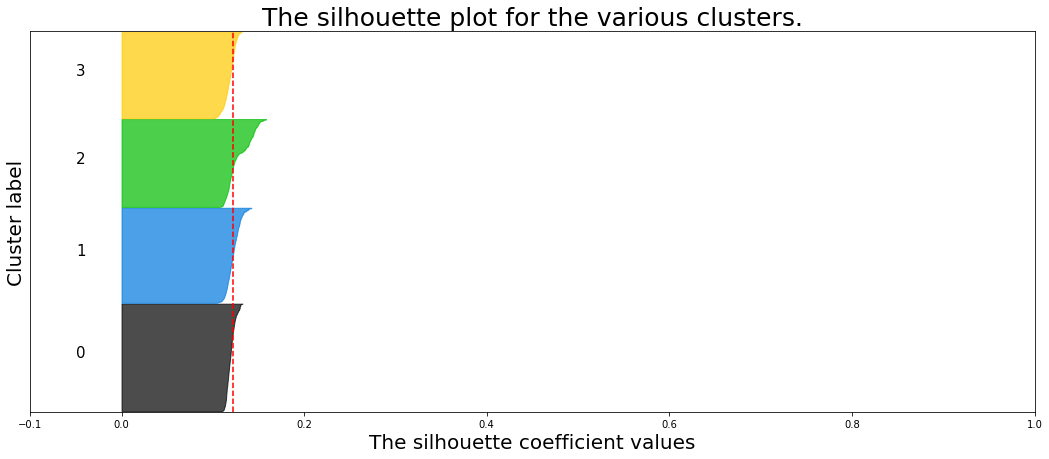

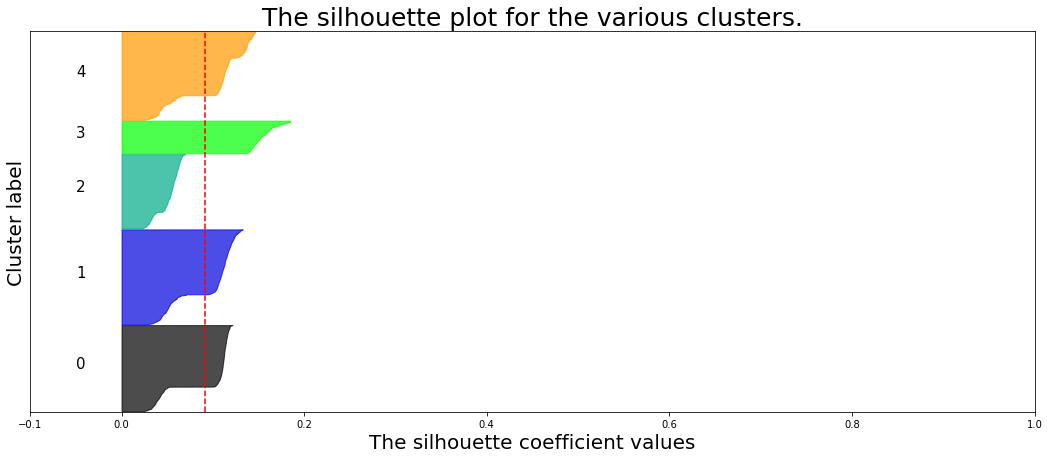

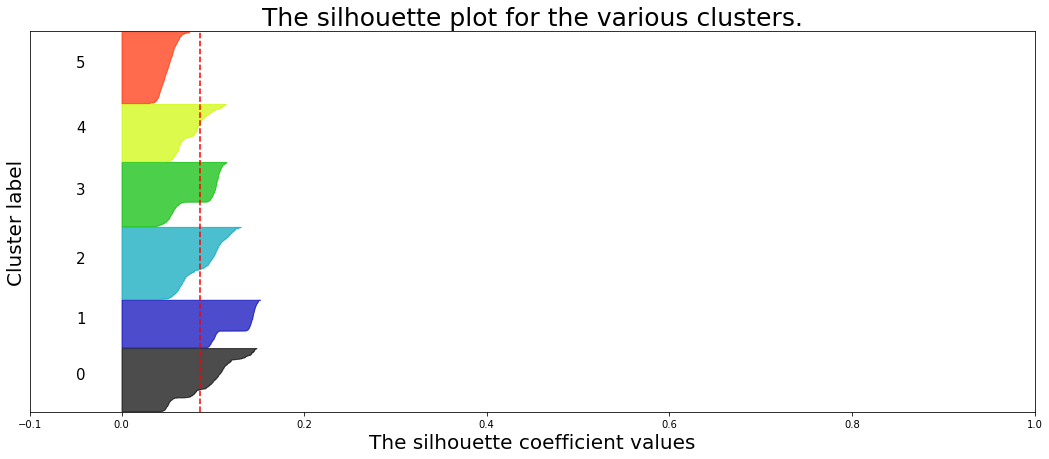

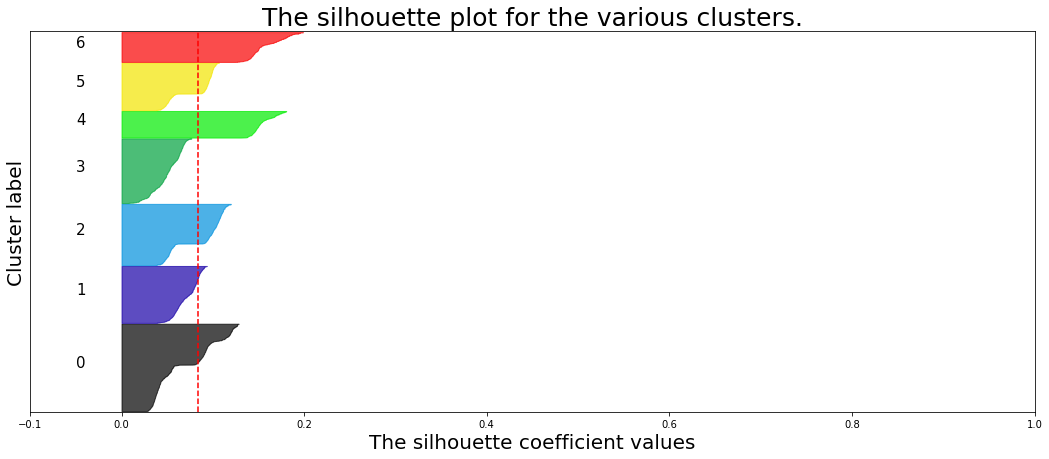

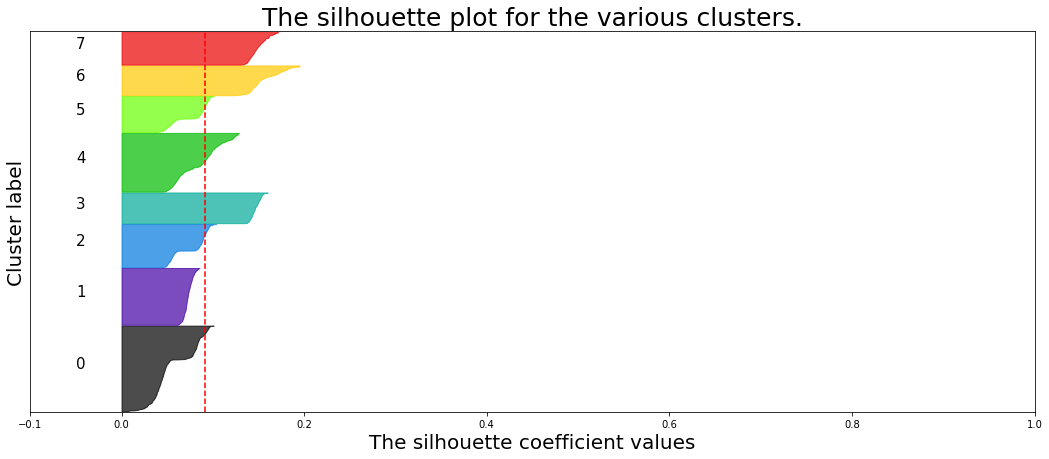

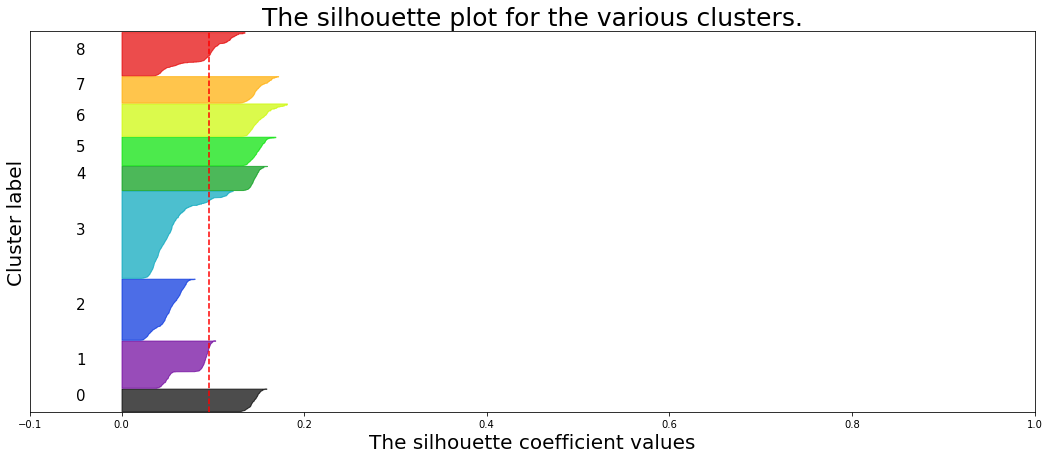

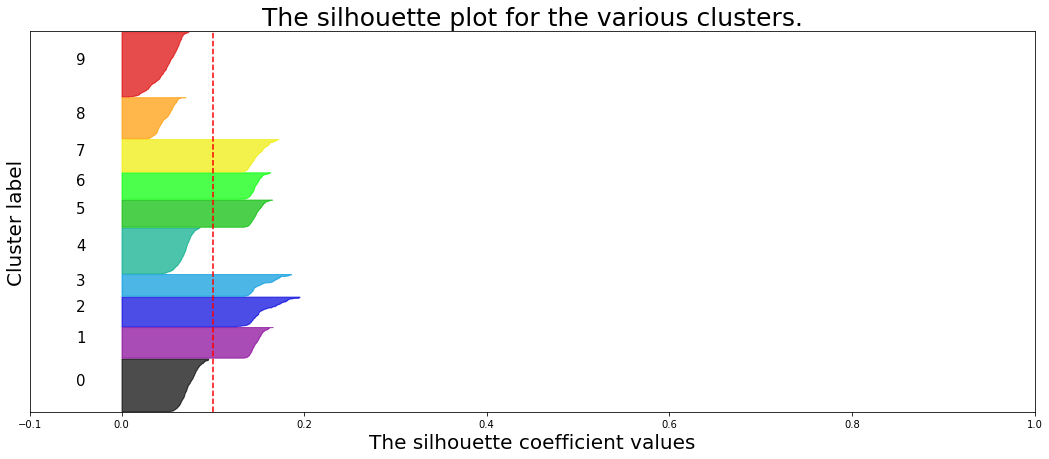

In [17]:
# The article from "https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html" was 
# used to help implement the loop

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

k_vals = range(2,11)
silhouette_scores = []

for num_clusters in k_vals:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dummy_sample_np_arr) + (num_clusters + 1) * 10])

    # Initialize the clusterer with k value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=num_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dummy_sample_np_arr)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dummy_sample_np_arr, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For k =", num_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dummy_sample_np_arr, cluster_labels)

    y_lower = 10
    for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=15)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=25)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=20)
    ax1.set_ylabel("Cluster label", fontsize=20)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

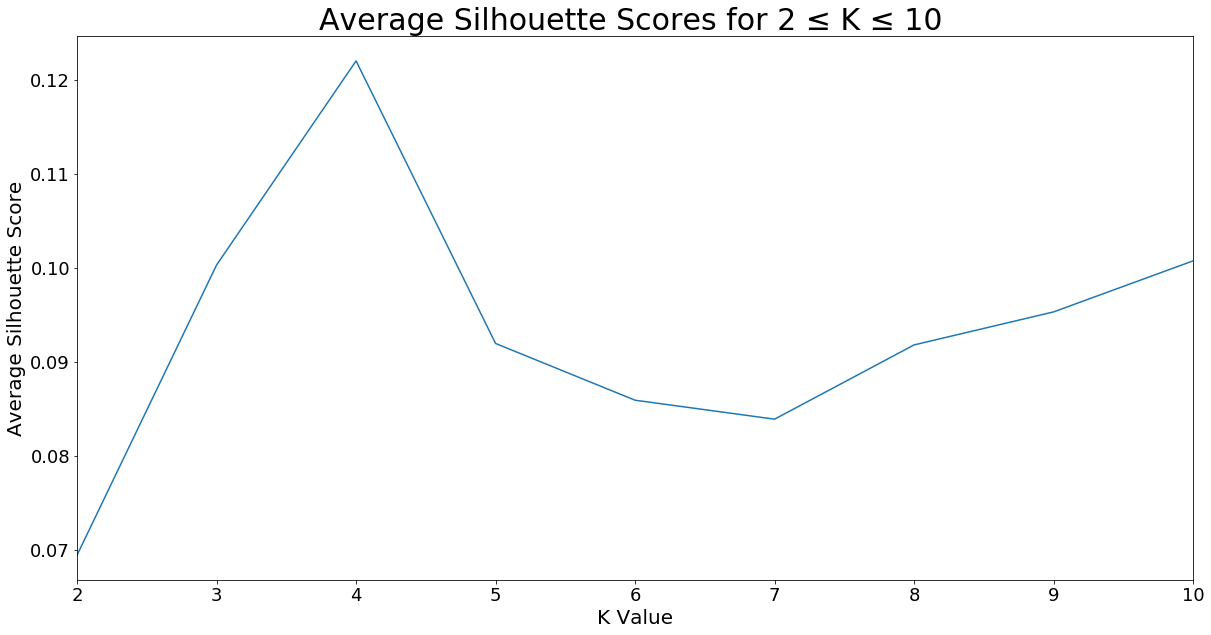

In [20]:
# Plot the average silhouette scores for 2<=k<=10
plt.figure(figsize=(20,10))
    
plt.plot(range(2, 11), silhouette_scores)
plt.xlim([2,10])
plt.xlabel('K Value', fontsize=20)
plt.ylabel('Average Silhouette Score', fontsize=20)
plt.xticks(range(2,11), size = 18)
plt.yticks(size = 18)
plt.title('Average Silhouette Scores for 2 ≤ K ≤ 10 ', size=30)
plt.show()

#### Response:
From the Silhouette method as well, it is clear from that graph that k=4 is the peak and would be the best k-value for me to build my k-means model around.

## Building K-Means model with k=4